# Лабораторная работа 1. Классические методы построения рекомендаций.

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit.

Вопросы по заданию можно писать в чат курса или на почту, которая будет дана в чате курса. Ссылка на форму для отправки решений будет дана в чате.

In [92]:
import pandas as pd
import numpy as np

In [93]:
import random
import math
from copy import deepcopy
from collections import defaultdict
from scipy.sparse import csr_matrix, dok_matrix

In [94]:
K = 20
SEED = 123
np.random.seed(SEED)

### Напишем некоторые вспомогательные функции, которые понадобятся нам далее

In [95]:
def get_user_group(user_id, df):
  grouped = df.groupby('user_id')
  for user_group in grouped: #! not optimal
    if user_group[1]['user_id'].tolist()[0] == user_id: #! not optimal
      return user_group
  return None

def leave_top_k(pred: pd.DataFrame,
                 k: int,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False)) #? if here we wan to predict the most relevance items, so we put the ascending=True
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [96]:
!pip install rs-datasets

In [97]:
from rs_datasets import MovieLens

In [98]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [99]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [100]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(8) #! the parametr represents amount of table lines

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59


Рассмотрим распределение по оценкам, которые пользователи дают фильмам. Из графика видно, что чаще всего люди дают оценки 4 или 3 (середина рейтинговой шкалы).

<BarContainer object of 5 artists>

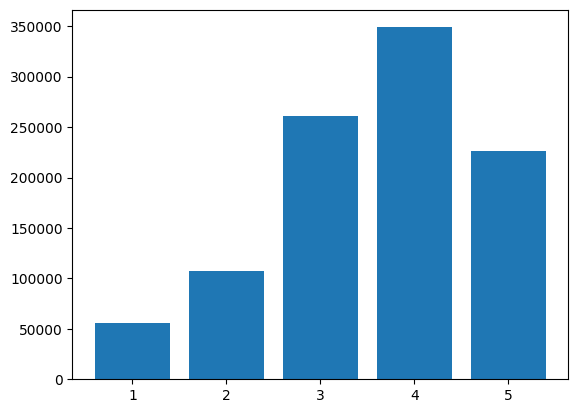

In [101]:
import matplotlib.pyplot as plt
# построим распределение оценок
grp = reviews.groupby('relevance')
marks_count = grp.size().tolist()
plt.bar(range(1, len(marks_count)+1), marks_count)

Построим график частоты оценивания фильмов -- насколько много пользователи оценивали фильмы в промежутке с 2000 по 2003 год. На графике можно четко видет два ярких пика активности. Из графика становится понятно, почему в задании просят разделить данные на тренировочную и валидационную выборки именно таким образом (данные до 1 декабря 2000 года не включая - данные train, данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные).

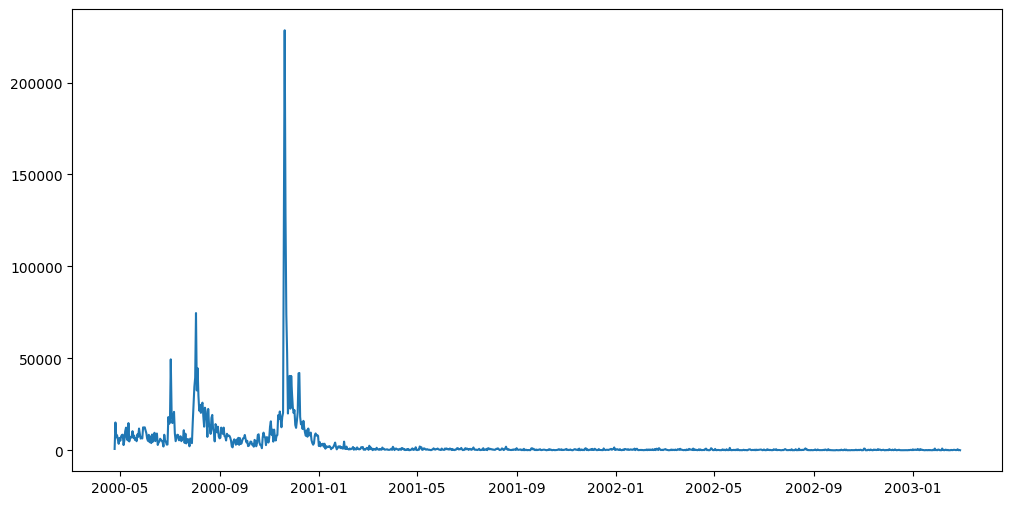

In [102]:
df = reviews.groupby(pd.Grouper(key='timestamp', axis=0,
                      freq='1D', sort=True)).sum()
plt.figure(figsize=(12, 6))
plt.plot(df['relevance'])

Заведем вспомогательную функцию для анализа квантилей оценок на пользователя и на фильм.

In [103]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

Построим график, по которому оценим, на сколько часто пользователи оценивают фильмы. По шкале абцис -- количество оценок, по оси ординат -- количество пользователей, которые ставят не более такого количество. Из графика можно сделать следующие выводы:
- все пользователи в таблице дали хотя бы 20 оценок (нет мертвых пользователей)
- в основном количество оценок, даваемое пользователем не привышает 200
- мало пользователей ставит большое количество оценок

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
5%         23.000000
25%        44.000000
50%        96.000000
75%       208.000000
95%       556.000000
max      2314.000000
Name: relevance, dtype: float64


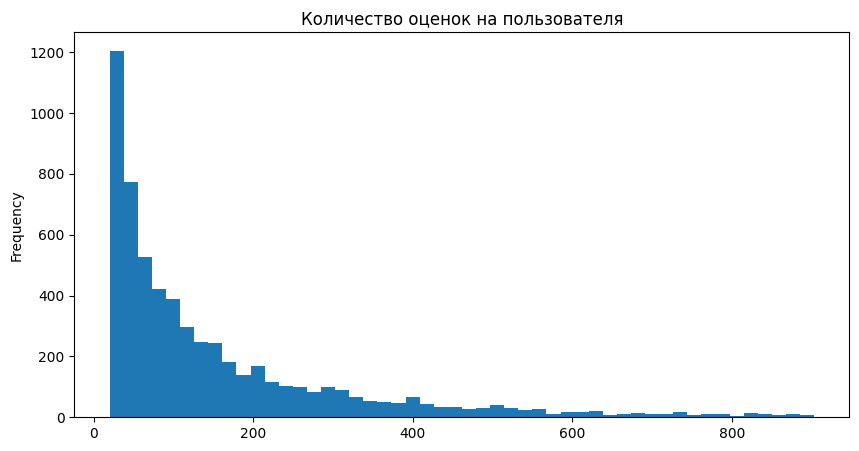

In [104]:
user_count = group_by_and_plot(reviews, group_by_name='user_id', rating_col_name='relevance', quantile=0.99, title='Количество оценок на пользователя')

Построим график, по которому оценим, на сколько часто оценивается каждый фильм.По шкале абцис -- количество оценок, по оси ординат -- фильмов, которые оцениваются не более чем таким количеством оценок. Из графика можно сделать следующие выводы:
- каждый фильм получил хотя бы по одной оценке
- в основном один фильм оценивается не более 250 раз
- мало фильмов имеет большое количество оценок

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
5%          2.000000
25%        33.000000
50%       123.500000
75%       350.000000
95%      1051.500000
max      3428.000000
Name: relevance, dtype: float64


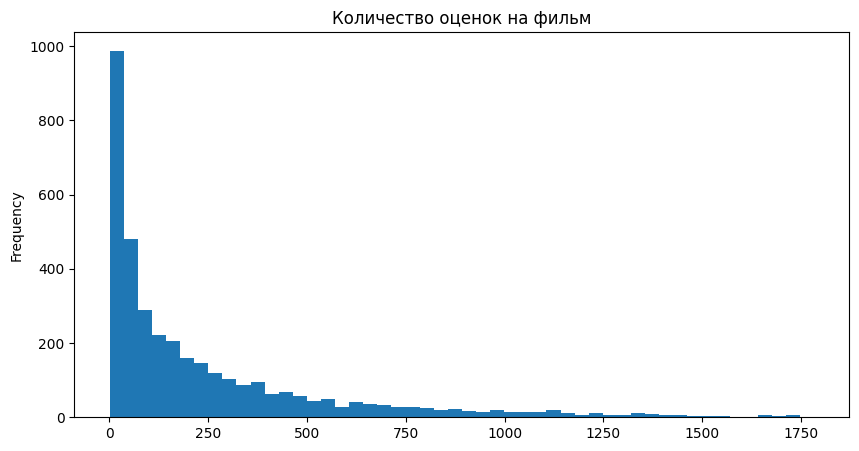

In [105]:
item_count = group_by_and_plot(reviews, group_by_name='item_id', rating_col_name='relevance', quantile=0.99, title='Количество оценок на фильм')

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

Разделим датасет на train и validation

In [106]:
train = reviews.loc[reviews['timestamp'] < '2000-12-01']
test  = reviews.loc[reviews['timestamp'] <= '2000-12-31'].loc[reviews['timestamp'] >= '2000-12-01']
print('Train Dataset:', train.shape)
print('Test Dataset:', test.shape)

Train Dataset: (791270, 4)
Test Dataset: (111315, 4)


Из валидационного датасета удалим неудовлетворительные оценки. Удовлетворительными считаются оценки 4 и 5. Таким образом, в валидационном датасете остались только те пары user-item, которые имеют положительный relevance.

In [107]:
test = test[test['relevance'] > 3]
print('Train Dataset:', train.shape)
print('Test Dataset:', test.shape)
test.head(10)

Train Dataset: (791270, 4)
Test Dataset: (64036, 4)


,user_id,item_id,relevance,timestamp
1205,11,1188,4,2000-12-30 23:51:59
1217,11,1198,4,2000-12-30 23:28:33
1218,11,593,5,2000-12-30 23:40:07
1226,11,1923,5,2000-12-30 23:53:13
1227,11,2580,5,2000-12-30 23:47:10
1228,11,1784,5,2000-12-30 23:45:17
1229,11,318,5,2000-12-30 23:39:07
1232,11,1358,5,2000-12-30 23:42:56
1241,11,3105,5,2000-12-30 23:41:42
1244,11,764,5,2000-12-30 23:44:29


После деления по времени в валидации могут оказаться пользователи, отсутствующие в train. Их считаем холодными (модель их не видела при обучении) и удаляем из валидационной части.

In [108]:
from tqdm import tqdm
train_users_set = set(train['user_id'].tolist())
test_users_set = set(test['user_id'].tolist())
set_intersection = train_users_set.intersection(test_users_set)

for usr in tqdm(test_users_set):
  if usr not in set_intersection:
    idx = test[test['user_id'] == usr].index
    idx.tolist()
    test = test.drop(idx.tolist())

100%|██████████| 1181/1181 [00:02<00:00, 500.48it/s]


In [109]:
# YOUR CODE HERE
train = train
val = test

In [110]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

Сделаем отдельный тренировочный набор только с положительными оценками.

In [111]:
positive_train = train[train['relevance'] > 3]

Заведем тестового юзера, на котором будем простатривать работу моделей. А так же тестовый item, на котором будем смотреть результат работы метода most_similar моделей из библиотеки implicit.

In [112]:
TEST_USER_ID = 670
TEST_ITEM_ID = 1248

Заведем вспомогательную функцию, которая позволяет посмотреть список фильмов, которые оценивал указанный пользователь, чтобы сравнить их потом с рекомендованными фильмами.

In [113]:
def get_user_marked_items(user_id, df):
  test_usr_group = get_user_group(user_id, df)
  assert(test_usr_group != None)
  user_marked_items_idx = test_usr_group[1]['item_id'].tolist()

  df = data.items[data.items['item_id'].isin(user_marked_items_idx)]
  return df

Рассмотрим, какие фильмы смотрел тестовый юзер в соответствии с данными из тренировочного датасета. На основе этих данных далее можно будет в человекочитаемом виде оценивать, насколько хорошо модель рекомендует нам новые фильмы.

In [114]:
get_user_marked_items(TEST_USER_ID, train)

,item_id,title,genres
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
72,73,"Misérables, Les (1995)",Drama|Musical
109,111,Taxi Driver (1976),Drama|Thriller
287,290,Once Were Warriors (1994),Crime|Drama
309,312,Stuart Saves His Family (1995),Comedy
...,...,...,...
3841,3911,Best in Show (2000),Comedy
3845,3915,Girlfight (2000),Drama
3865,3935,Kronos (1973),Horror
3878,3948,Meet the Parents (2000),Comedy


In [115]:
get_user_marked_items(TEST_USER_ID, val)

,item_id,title,genres
896,908,North by Northwest (1959),Drama|Thriller
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1229,1249,Nikita (La Femme Nikita) (1990),Thriller
1230,1250,"Bridge on the River Kwai, The (1957)",Drama|War
1239,1259,Stand by Me (1986),Adventure|Comedy|Drama
2555,2624,After Life (1998),Drama


In [116]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [117]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


Внутри моделей implicit жестко захардкожены названия полей: datetime вместо timestamp, weight вместо relevance. Без этого модели выдают ошибку.

In [118]:
train.rename(columns={"timestamp": "datetime"}, inplace=True)
train.rename(columns={"relevance": "weight"}, inplace=True)

val.rename(columns={"timestamp": "datetime"}, inplace=True)
val.rename(columns={"relevance": "weight"}, inplace=True)

<ipython-input-118-976deb36a56a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={"timestamp": "datetime"}, inplace=True)
<ipython-input-118-976deb36a56a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={"relevance": "weight"}, inplace=True)


Issue 167 в пакете implicit, необходимо привести веса к типу float, иначе метод recommend выдает ошибку.

In [119]:
val['weight'] = pd.to_numeric(val['weight'], downcast='float')
train['weight'] = pd.to_numeric(train['weight'], downcast='float')

<ipython-input-119-ee60b2884c59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weight'] = pd.to_numeric(train['weight'], downcast='float')


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

Сгенерируем для каждого пользователя из валидационной выборки 20 рандомных рекомендаций. Так же каждой рандомной рекомендации приписываем рандомный relevance.

In [120]:
def get_n_random_items(n, dataset):
  random_items = dataset.items.sample(n=n, random_state=random.randint(0, 100))
  random_items_idx = random_items['item_id'].tolist()
  return random_items_idx

def make_random_pred(user_list, dataset, N):
  df = pd.DataFrame()
  for user_id in tqdm(user_list):
    random_items = get_n_random_items(N, data)
    for item in random_items:
      new_row = {}
      new_row['user_id'] = user_id
      new_row['item_id'] = item
      # in this task we assume that we make a random relevance to recommended item
      new_row['relevance'] = random.randint(1, 5)
      s = pd.Series(new_row)
      df = pd.concat([df, s.to_frame().T])
  return df

In [121]:
%%time
# YOUR CODE HERE
user_list = set(val['user_id'].tolist())
random_pred = make_random_pred(user_list, train, K)
random_pred.head(10)

100%|██████████| 522/522 [00:09<00:00, 55.63it/s]

CPU times: user 9.14 s, sys: 232 ms, total: 9.37 s
Wall time: 9.39 s


,user_id,item_id,relevance
0,2050,2219,3
0,2050,2422,3
0,2050,548,2
0,2050,3378,1
0,2050,564,2
0,2050,1180,4
0,2050,2690,4
0,2050,2503,3
0,2050,176,1
0,2050,3408,1


In [122]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [123]:
random_pred.head(1)

,user_id,item_id,relevance
0,2050,2219,3


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [124]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    Reli = len(row['gt_list'])
    pred_list = row['pred_list']
    dcg = 0
    counter = 0
    for j, item in enumerate(pred_list):
      if counter >= k: break
      counter += 1
      if item in row['gt_list']:
        dcg += 1 / (math.log2(j+1+1))

    idcg = 0
    counter = 0
    for j in range(Reli):
      if counter >= k: break
      counter += 1
      idcg += 1 / (math.log2(j+1+1))

    if idcg == 0: return 0
    ndcg = dcg / idcg
    return ndcg

In [125]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [126]:
# YOUR CODE HERE: оценка NDCG для всех пользователей. На вход приходят рекомендации в формате как в задании 3
def nDCG(pred, true, k):
  pred_cropped = leave_top_k(pred, k)
  # prepare score lists
  pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
  gt_grouped = true.groupby('user_id')['item_id'].apply(list).rename('gt_list')
  to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
  to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else []) # если нет оценок, записываем пустой лист (хотим сделать так, чтобы в ячейках датафрэйма лежали листы)

  sumNDCG = 0
  N = pred['user_id'].nunique()
  for _, row in to_compare.iterrows():
    sumNDCG += ndcg_user(row, k)
  return sumNDCG / N

Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [127]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        # в этом словаре мы для каждого item_id сохраним количество пользователей, которые оценивали этот item
        self.items_marks_count = {}
        self.N = log['user_id'].nunique() # число пользователей в обучающей выборке

        grouped = log.groupby('item_id')
        for grp in grouped:
          marks_count = grp[1]['user_id'].count()
          self.items_marks_count[grp[1]['item_id'].tolist()[0]] = marks_count # not optimal

    def get_item_self_info(self, item_id):
      # учитываем холодные items
      if item_id in self.items_marks_count.keys():
        return -math.log2(self.items_marks_count[item_id] / self.N)
      else:
        return -math.log2(1 / self.N)

    def __call__(self, pred, k):
        top_k_pred = leave_top_k(pred, k)
        surprisal = 0

        uniq_users_amount = top_k_pred['user_id'].nunique()
        grouped = top_k_pred.groupby('user_id')
        for grp in grouped:
          sum_self_info = grp[1]['item_id'].apply(self.get_item_self_info)
          sum_self_info = sum_self_info.sum()
          # k_marks = grp[1]['user_id'].count()
          # surprisal += sum_self_info / (math.log2(self.N) * k_marks)
          surprisal += sum_self_info / (math.log2(self.N) * k)
        return surprisal / uniq_users_amount

In [128]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

Создадим объект с предподсчитанной статистикой по тренеровочной выбоке.

In [129]:
surp = Surprisal(train)

In [130]:
def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

def HitRate(pred, ground_truth, k):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    HR = to_compare.apply(user_hr, axis=1)
    return HR.mean()

Разберем, в чем состоит сокральный смысл каждой из метрик.
- Surprisal -- показввает, насколько рекомендованные объекты хороши для пользователя с точки зрения "новизны". Скажем, чем больше значение surprisal, тем более рекомендованные объекты являются "уникальными".
- Coverage -- показывает, как много объектов из обучающей выборки используется для рекомендаций. Если coverage маленький, то система рекомендует всем пользователям одни и те же объекты из малого подмножества. Если coverage большой -- система охватывает широкий спектр рекомендуемых пользователю объектов.
- nDCG -- оценивает точность рекомендаций + учитывает порядок расположения объектов в списке рекомендаций.
- Hit rate -- показывает процент релевантных товаров. То есть, какой процент товаров из рекомендованных пользователь реально приобрел.

Для каждой метрики заведем словарь. В словаре будем хранить имя модели и значение соответствующей матрики.

In [131]:
HIT_RATE = {}
COVERAGE = {}
N_DCG = {}
SURPRISAL = {}

In [132]:
COVERAGE['random'] = coverage(random_pred, K, train['item_id'].drop_duplicates())
HIT_RATE['random'] = HitRate(random_pred, val, K)
N_DCG['random'] = nDCG(random_pred, val, K)
SURPRISAL['random'] = surp(random_pred, K)

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

Сделаем вспомогательную функцию, которая принимает список юзеров, для которых нужно сделать рекомендацию, модель, количество запрашиваемых рекомендаций и матрицу user-item для генерации рекомендаций.

In [133]:
def make_recommendation_table(user_list, model, N, user_item_matrix):
  recomendations, weights = model.recommend(user_list,
                                   csr_matrix(user_item_matrix[list(user_list)]), N=N,
                                   filter_already_liked_items=True,
                                   filter_items=None,
                                   recalculate_user=True)

  df = pd.DataFrame({'user_id': np.array(list(user_list)).repeat(N), 'item_id': recomendations.reshape(-1), 'relevance': weights.reshape(-1)})

  for col, dtype in zip(['user_id', 'item_id', 'relevance'], (np.int32, np.int32, np.float32)):
        df[col] = df[col].astype(dtype)

  return df

In [134]:
! pip install implicit

In [135]:
import implicit

На вход моделям из пакета implicit нужно подавать матрицу user-item. А нас изначально в датасете таблицы другого вида. Поэтому нужно имеющиеся данные преобразовать к матрице user-item.

Если формировать реальные матрицы, они будут сильно разреженные, большую часть оперативной памяти будут занимать бесполезные нули (на тех местах, где юзеры никак не взаимодействовали с обхектами). Поэтому сформируем sparse матрицы, что позволит нам оптимизировать обучение и экономить место в памяти (аналог использования списка связности вместо матрицы связности в графах).

In [136]:
def get_sparse_matrix(train_df):
  user_num = train["user_id"].max() + 1
  item_num = train["item_id"].max() + 1

  train_mat = defaultdict(float)
  for _, user, item, rel in train[["user_id", "item_id", "weight"]].itertuples():
      train_mat[user, item] = rel
  user_item = dok_matrix((user_num, item_num), dtype=np.float32)
  dict.update(user_item, train_mat)
  return user_item

In [137]:
%%time
user_item_train_matrix = get_sparse_matrix(train)

CPU times: user 1.03 s, sys: 121 ms, total: 1.15 s
Wall time: 1.29 s


Исследуем зависимость оценки модели KNN от гиперпараметра K (то есть от количества соседей). Для этого проварьируем параметр от 2 до 30, создадим соответствующие модели, обучим и оценим качество рекомендаций, которые они дают.

In [138]:
neighbours_amnt = range(2, 30+1, 2)
coverage_list = []
n_dcg_list = []
hit_rate_list = []
surprise_list = []

In [139]:
knn_models_list = []
for n in neighbours_amnt:
  model = implicit.nearest_neighbours.CosineRecommender(n)
  knn_models_list.append(model)

Обучим все модели, сделаем предсказания с их помощью и посмотрим, как изменяются метрики качества в зависимости от параметра K модели.

In [140]:
for knn_model in tqdm(knn_models_list):
  knn_model.fit(user_item_train_matrix,
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.056112051010131836 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:04<01:00,  4.31s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0554964542388916 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:07<00:50,  3.86s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.05145096778869629 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:11<00:44,  3.70s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03233647346496582 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:13<00:33,  3.06s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04255247116088867 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:15<00:27,  2.80s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03332376480102539 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 40%|████      | 6/15 [00:17<00:21,  2.43s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04084134101867676 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 47%|████▋     | 7/15 [00:19<00:17,  2.14s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.032740116119384766 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 53%|█████▎    | 8/15 [00:20<00:13,  1.97s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03291010856628418 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 60%|██████    | 9/15 [00:22<00:11,  1.84s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.034501075744628906 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 67%|██████▋   | 10/15 [00:23<00:08,  1.75s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03247642517089844 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 73%|███████▎  | 11/15 [00:25<00:06,  1.70s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03410768508911133 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 80%|████████  | 12/15 [00:27<00:05,  1.76s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04695701599121094 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 87%|████████▋ | 13/15 [00:29<00:03,  1.88s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03364109992980957 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 93%|█████████▎| 14/15 [00:31<00:01,  1.80s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03277158737182617 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


In [141]:
for knn_model in knn_models_list:
  recommendation_table = make_recommendation_table(user_list, knn_model, K, user_item_train_matrix)

  coverage_list.append(coverage(recommendation_table, K, train['item_id'].drop_duplicates()))
  n_dcg_list.append(nDCG(recommendation_table, val, K))
  hit_rate_list.append(HitRate(recommendation_table, val, K))
  surprise_list.append(surp(recommendation_table, K))

Построим графики зависимости каждой из 4 метрик от величины гиперпараметра модели.

Text(0.5, 1.0, 'Зависимость метрики Surprisal от количества соседей')

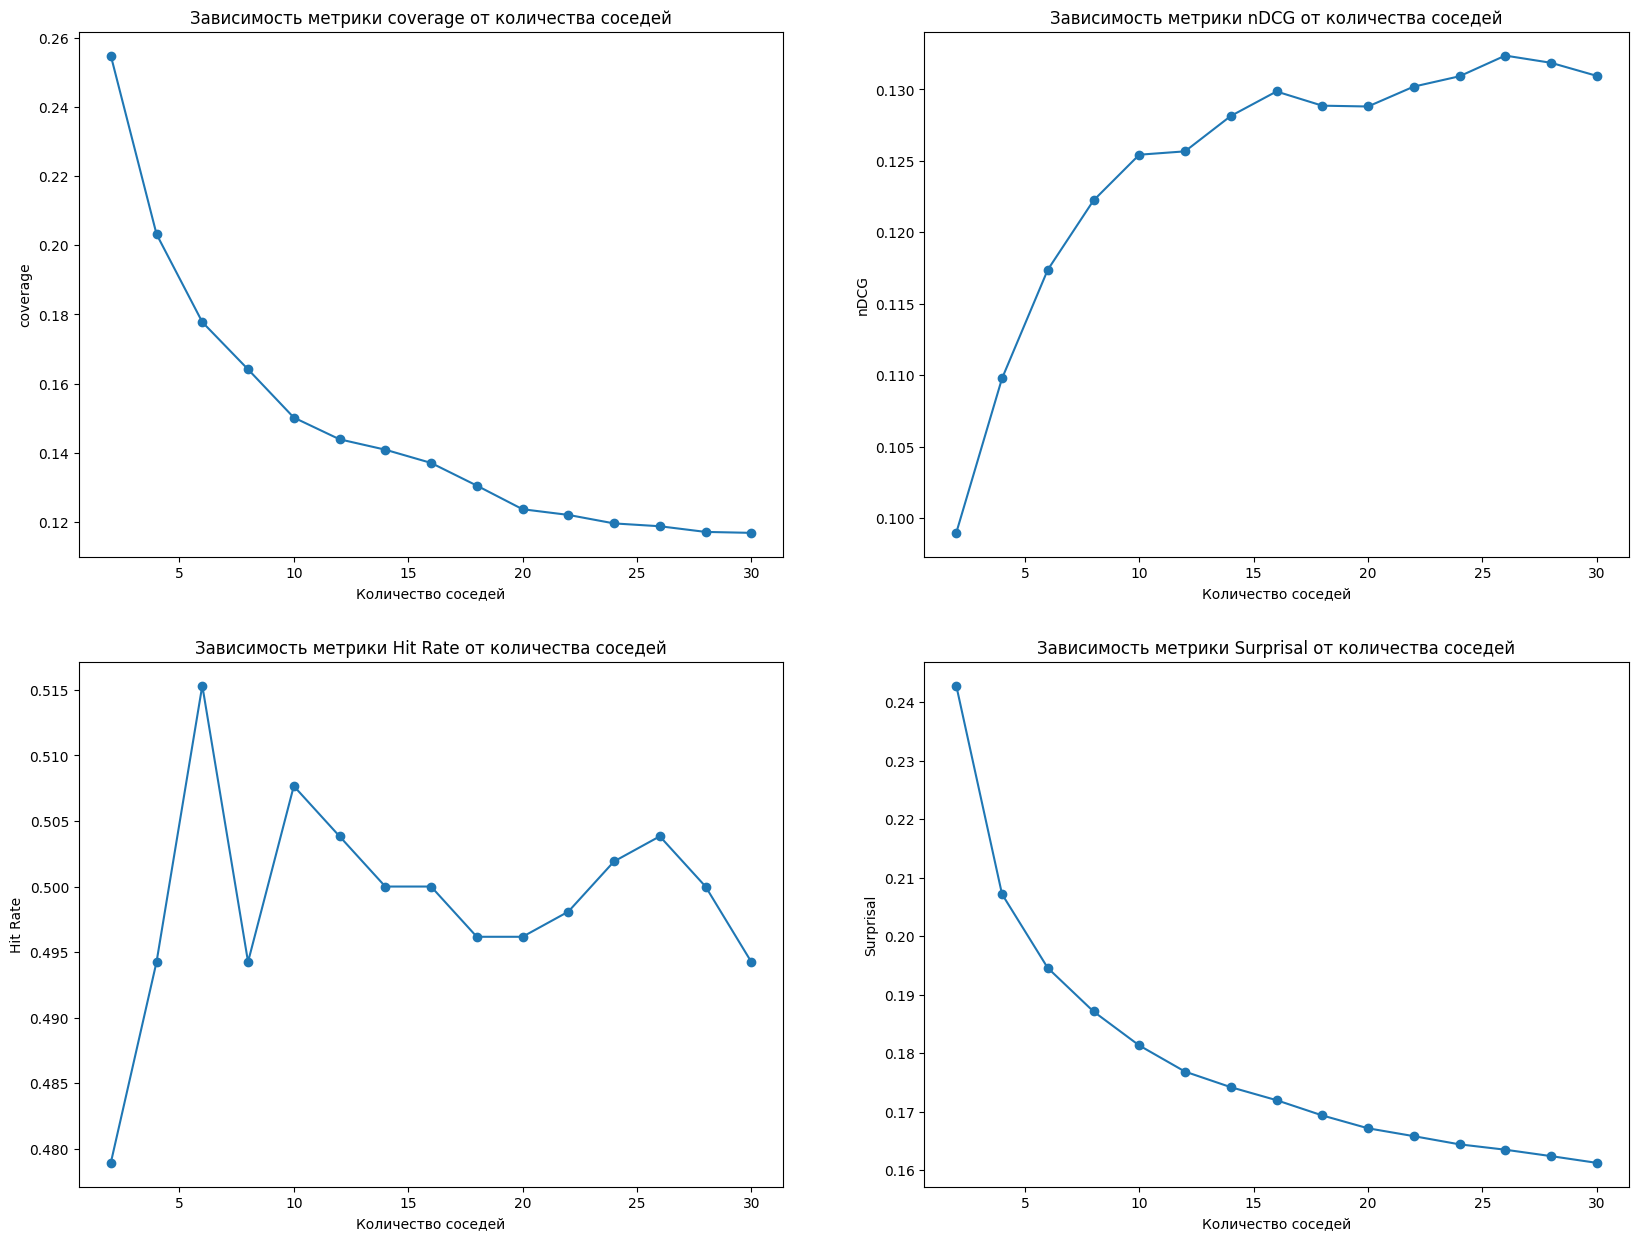

In [142]:
plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.scatter(neighbours_amnt, coverage_list)
plt.plot(neighbours_amnt, coverage_list)

plt.xlabel("Количество соседей")
plt.ylabel("coverage")
plt.title(f"Зависимость метрики coverage от количества соседей")

plt.subplot(2,2,2)
plt.scatter(neighbours_amnt, n_dcg_list)
plt.plot(neighbours_amnt, n_dcg_list)

plt.xlabel("Количество соседей")
plt.ylabel("nDCG")
plt.title(f"Зависимость метрики nDCG от количества соседей")

plt.subplot(2,2,3)
plt.scatter(neighbours_amnt, hit_rate_list)
plt.plot(neighbours_amnt, hit_rate_list)

plt.xlabel("Количество соседей")
plt.ylabel("Hit Rate")
plt.title(f"Зависимость метрики Hit Rate от количества соседей")

plt.subplot(2,2,4)
plt.scatter(neighbours_amnt, surprise_list)
plt.plot(neighbours_amnt, surprise_list)

plt.xlabel("Количество соседей")
plt.ylabel("Surprisal")
plt.title(f"Зависимость метрики Surprisal от количества соседей")

Проанализируем полученные результаты. С увеличением количества соседей метрики Coverage и Surprisal ожидаемо падают. Модель запоминает все больше и больше соседей и диапазон "подходящих" для рекомендаций фильмов сужается.

Метрика nDCG наоборот растет. Чем больше соседей запомнила модель, тем более похожие предсказания она сделает.

Наиболее интересно ведет себя Hit Rate -- сначала метрика возрастает, а потом падает. Предполагается, что в некоторый момент происходит что-то вроде переобучения модели и ее оценка становится хуже.

Разберем основной смысл использования весов tfidf и bm25. Предположим, что у нас есть пользователи i и j. i-й пользователь дал оценку 100 фильмам, j-й пользователь дал оценку 2м фильмам. Чья рекомендация будет более конструктивной? На уровне элементарной логики, наверное, к i-му пользователю доверия несколько больше, так как у него "больше опыта для сравнения". Нам бы хотелось как-то учесть эту особенность. На данный момент наши модели учитывают подобных пользователей в одинаковой мере.
Необходимо присвоить оценкам пользователей некоторый веса, причем, пользователям, который оценивали больше разных фильмов нужно присвоить бОльшие веса.

Рассмотрим модели из пакета implicit, поддерживающие взвешивание данных по эвристикам tfidf и bm25. Сделаем дополнительные разделение train данных, чтобы исследовать влияние гиперпараметров этих моделей на качество оценки.

In [143]:
tfidf_model = implicit.nearest_neighbours.TFIDFRecommender(30)
tfidf_model.fit(user_item_train_matrix,
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.032462120056152344 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

Заведем функцию, которая по списку индексов рекомендованных объектов может вывести информацию по ним.

In [144]:
def get_recommended_movies_info(items_idx_list: list):
  df = data.items[data.items['item_id'].isin(items_idx_list)]
  return df

Рассмотрим, какие фильмы модель считает наиболее близкими к тестовому объекту.

In [145]:
closest, relevance = tfidf_model.similar_items(TEST_ITEM_ID, N=10)
get_recommended_movies_info(closest)

,item_id,title,genres
901,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
918,930,Notorious (1946),Film-Noir|Romance|Thriller
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1232,1252,Chinatown (1974),Film-Noir|Mystery|Thriller
1240,1260,M (1931),Crime|Film-Noir|Thriller
1247,1267,"Manchurian Candidate, The (1962)",Film-Noir|Thriller
1264,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
2117,2186,Strangers on a Train (1951),Film-Noir|Thriller
3366,3435,Double Indemnity (1944),Crime|Film-Noir


Попробуем сделать K рекомендаций для выбранного тестового юзера и посмотрим, какие фильмы выдаст модель.

In [146]:
recommendation = tfidf_model.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix[TEST_USER_ID]),
                        N=K,
                        filter_already_liked_items=True, # фильтрует фильмы, которые пользователь уже смотрел
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
293,296,Pulp Fiction (1994),Crime|Drama
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
847,858,"Godfather, The (1972)",Action|Crime|Drama
891,903,Vertigo (1958),Mystery|Thriller
896,908,North by Northwest (1959),Drama|Thriller
901,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1120,1136,Monty Python and the Holy Grail (1974),Comedy


Сделаем по K рекомендаций для каждого пользователя из тестового набора.

In [147]:
tifidf_recommendations = make_recommendation_table(user_list, tfidf_model, K, user_item_train_matrix)

In [148]:
COVERAGE['tifidf'] = coverage(tifidf_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['tifidf'] = HitRate(tifidf_recommendations, val, K)
N_DCG['tifidf'] = nDCG(tifidf_recommendations, val, K)
SURPRISAL['tifidf'] = surp(tifidf_recommendations, K)

Теперь рассмотрим модель с взвешиванием данных bm25.

In [149]:
bm25_model = implicit.nearest_neighbours.BM25Recommender(200)
bm25_model.fit(user_item_train_matrix,
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.046681880950927734 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

In [150]:
closest, relevence = bm25_model.similar_items(TEST_ITEM_ID, N=10)
get_recommended_movies_info(closest)

,item_id,title,genres
896,908,North by Northwest (1959),Drama|Thriller
901,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1232,1252,Chinatown (1974),Film-Noir|Mystery|Thriller
1240,1260,M (1931),Crime|Film-Noir|Thriller
1247,1267,"Manchurian Candidate, The (1962)",Film-Noir|Thriller
1264,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
2117,2186,Strangers on a Train (1951),Film-Noir|Thriller
3366,3435,Double Indemnity (1944),Crime|Film-Noir


In [151]:
recommendation = bm25_model.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix[TEST_USER_ID]),
                        N=K,
                        filter_already_liked_items=True,
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
293,296,Pulp Fiction (1994),Crime|Drama
315,318,"Shawshank Redemption, The (1994)",Drama
537,541,Blade Runner (1982),Film-Noir|Sci-Fi
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
847,858,"Godfather, The (1972)",Action|Crime|Drama
891,903,Vertigo (1958),Mystery|Thriller
896,908,North by Northwest (1959),Drama|Thriller
901,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller


In [152]:
bm25_recommendations = make_recommendation_table(user_list, bm25_model, K, user_item_train_matrix)

In [153]:
COVERAGE['bm25'] = coverage(bm25_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['bm25'] = HitRate(bm25_recommendations, val, K)
N_DCG['bm25'] = nDCG(bm25_recommendations, val, K)
SURPRISAL['bm25'] = surp(bm25_recommendations, K)

Повторим эксперимент, подав на моделям на вход тренировочный датасет только с положительными оцнеками и сравним результаты.

В соответствии с исследованием гиперпараметра, возмем наилучшую модель и обучим ее.

In [156]:
knn_model_6 = implicit.nearest_neighbours.CosineRecommender(6)
knn_model_6.fit(user_item_train_matrix,
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.045795440673828125 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

In [157]:
closest, relevance = knn_model_6.similar_items(TEST_ITEM_ID, N=K)
get_recommended_movies_info(closest)

,item_id,title,genres
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1232,1252,Chinatown (1974),Film-Noir|Mystery|Thriller
1247,1267,"Manchurian Candidate, The (1962)",Film-Noir|Thriller
2117,2186,Strangers on a Train (1951),Film-Noir|Thriller
3366,3435,Double Indemnity (1944),Crime|Film-Noir


Заведем вспомогательную функцию, которая возвращает информацию о фильмах по списку их индексов. Функцию будем использовать, чтобы сравнивать рекомендации с фильмами, которые пользователь реально оценивал.

In [158]:
recommendation = knn_model_6.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix[TEST_USER_ID]),
                        N=K,
                        filter_already_liked_items=True,
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
293,296,Pulp Fiction (1994),Crime|Drama
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
735,745,"Close Shave, A (1995)",Animation|Comedy|Thriller
891,903,Vertigo (1958),Mystery|Thriller
896,908,North by Northwest (1959),Drama|Thriller
901,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1195,1213,GoodFellas (1990),Crime|Drama
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy
1215,1234,"Sting, The (1973)",Comedy|Crime


In [160]:
knn_recommendations = make_recommendation_table(user_list, knn_model_6, K, user_item_train_matrix)

In [161]:
COVERAGE['knn'] = coverage(knn_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['knn'] = HitRate(knn_recommendations, val, K)
N_DCG['knn'] = nDCG(knn_recommendations, val, K)
SURPRISAL['knn'] = surp(knn_recommendations, K)

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

Построим модель ALS. TODO: написать про параметры.

Рассмотрим подробно, за что отвечает каждый из параметров модели:
- factors -- размер первой матрицы в разложении ALS. По-сути, показывает то, на сколько будут большими эмбединги пользователей (как много факторов мы хотим учитывать).
- regularisation -- в представлении не нуждается
- iterations -- количество итераций обучения. В методе ALS мы представляем исходную матрицу user-item произведением двух матриц, которые нам необходимо обучить. Изначально эти матрицы инициализируются случайными весами. Сначала фиксируется одна матрица (без ограничения общности, пусть это будет первая матрица), вторая матрица обучается так, чтобы наилучшим образом приблизить исходную матрицу user-item. Затем фиксируется вторая матрица и оптимизируется первая. Это одна итерация. Параметр iterations отвечает за то, во сколько итераций мы будем оптимизировать матрицы в разложении.

Создадим несколько моделей с различными значениями гиперпараметра (в данном случае будем варьировать количество факторов), чтобы исследовать влияние этого гиперпараметра на оценку модели.

In [162]:
factor_list = [x for x in range(2, 32+1, 2)]

coverage_list = []
n_dcg_list = []
hit_rate_list = []
surprise_list = []

als_models_list = []
for factor in tqdm(factor_list):
  als_models_list.append(
      implicit.als.AlternatingLeastSquares(
          factors=factor,
          regularization=0.0,
          iterations=16)
      )

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 16/16 [00:00<00:00, 463.01it/s]


In [163]:
for als_model in als_models_list:
  als_model.fit(user_item_train_matrix,
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.16845369338989258 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.16564631462097168 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.1828479766845703 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.2402186393737793 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.1702561378479004 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.24100446701049805 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.22927355766296387 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.38851451873779297 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.2352139949798584 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.25221991539001465 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.23786330223083496 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.21700549125671387 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.2299938201904297 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.22490715980529785 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.24226999282836914 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.23449325561523438 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

После обучения всех моделей сделаем рекомендации с помощью каждой из них и посмотрим на оценки.

In [164]:
for als_model in als_models_list:
  recommendation_table = make_recommendation_table(user_list, als_model, K, user_item_train_matrix)

  coverage_list.append(coverage(recommendation_table, K, train['item_id'].drop_duplicates()))
  n_dcg_list.append(nDCG(recommendation_table, val, K))
  hit_rate_list.append(HitRate(recommendation_table, val, K))
  surprise_list.append(surp(recommendation_table, K))

Построим графики зависимости 4 оценок модели от величины гиперпараметра.

Text(0.5, 1.0, 'Зависимость метрики Surprisal от количества факторов')

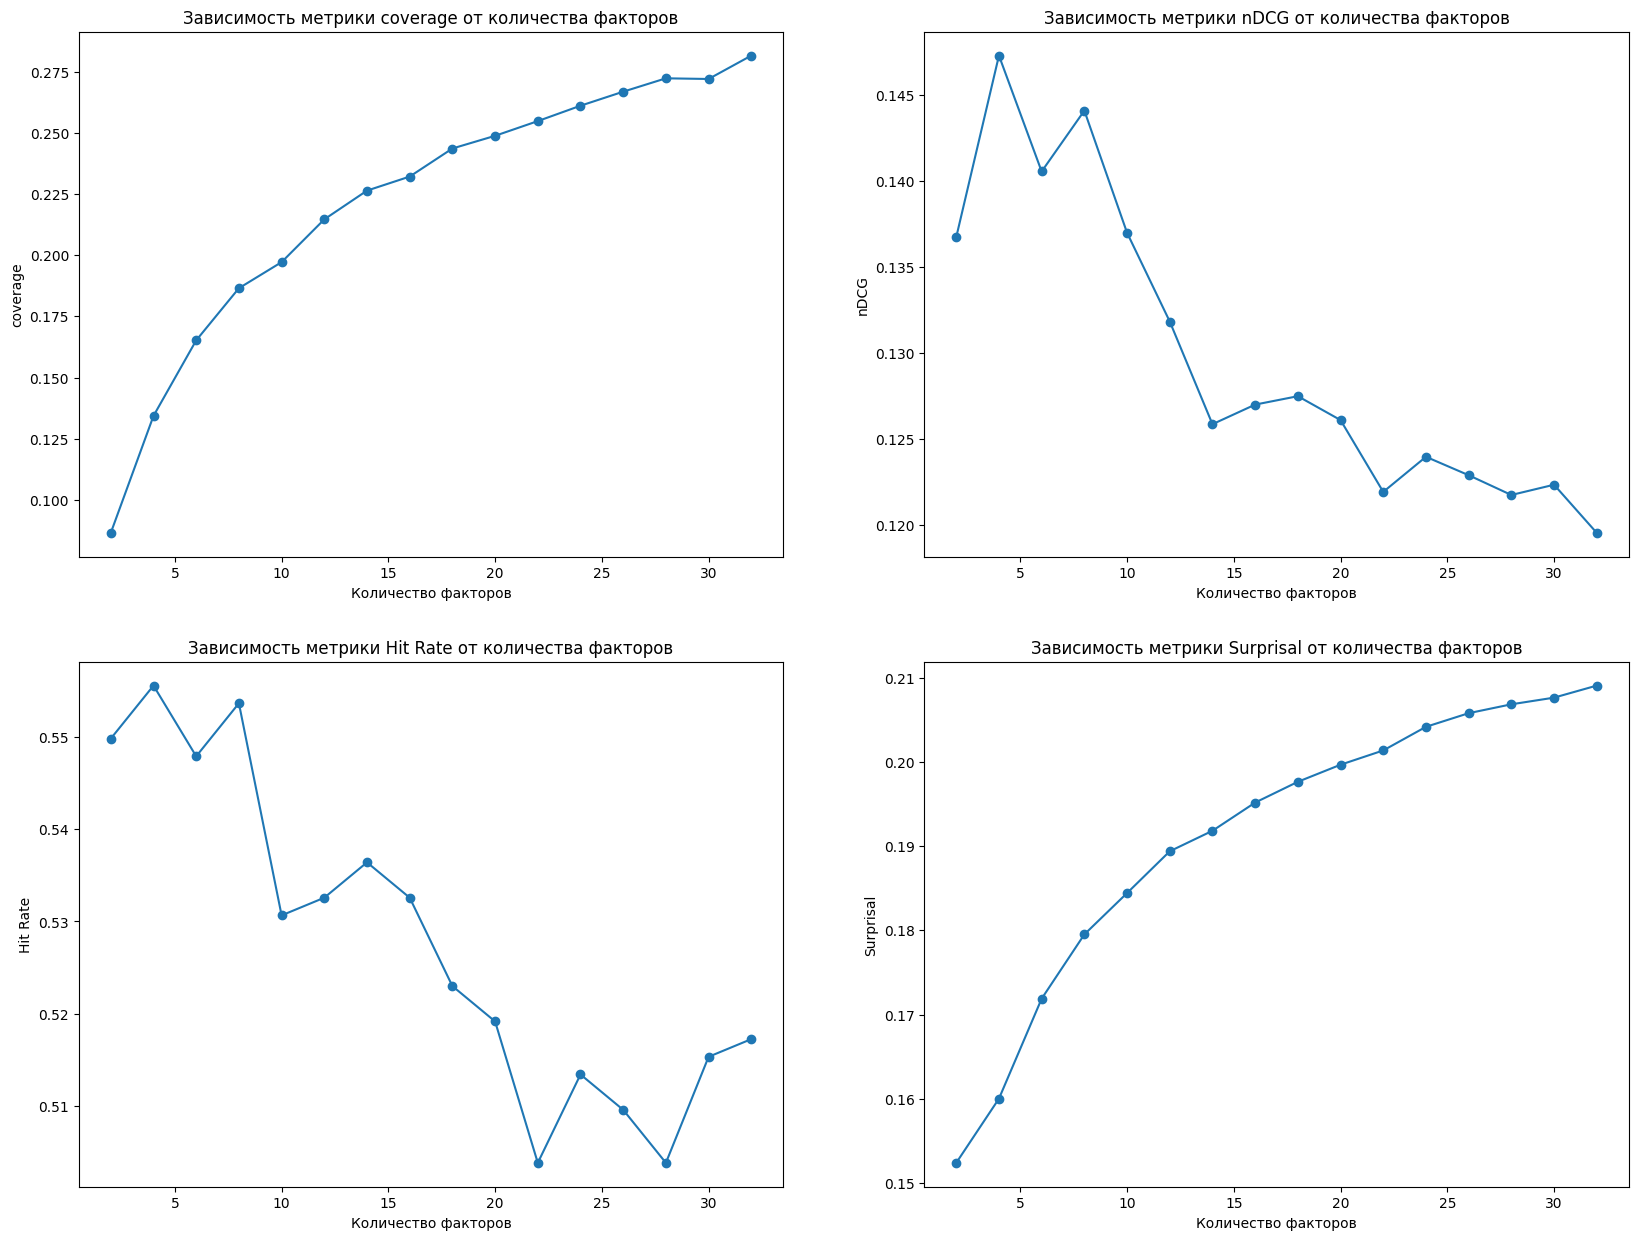

In [165]:
plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.scatter(factor_list, coverage_list)
plt.plot(factor_list, coverage_list)

plt.xlabel("Количество факторов")
plt.ylabel("coverage")
plt.title(f"Зависимость метрики coverage от количества факторов")

plt.subplot(2,2,2)
plt.scatter(factor_list, n_dcg_list)
plt.plot(factor_list, n_dcg_list)

plt.xlabel("Количество факторов")
plt.ylabel("nDCG")
plt.title(f"Зависимость метрики nDCG от количества факторов")

plt.subplot(2,2,3)
plt.scatter(factor_list, hit_rate_list)
plt.plot(factor_list, hit_rate_list)

plt.xlabel("Количество факторов")
plt.ylabel("Hit Rate")
plt.title(f"Зависимость метрики Hit Rate от количества факторов")

plt.subplot(2,2,4)
plt.scatter(factor_list, surprise_list)
plt.plot(factor_list, surprise_list)

plt.xlabel("Количество факторов")
plt.ylabel("Surprisal")
plt.title(f"Зависимость метрики Surprisal от количества факторов")

Проанализируем полученные результаты. Метрики coverage и surprisal растут с увеличением количества факторов. Количество факторов отвечает за то, насколько много индивидуальных особенностей пользователей мы будем учитывать (чем больше факторов, тем больше размерность вектора, представляющего пользователя в матрице; чем больше размерность такого вектора, тем больше информации мы можем в нем сохранить по аналогии с векторами эмбедингов).
Что касается непосредственно векторов качества модели, сначала с увеличением количества факторов они начинают расти, а затем падать. Предполагается, что слишком большое число факторов ведет к переобучению модели, поэтому при предсказании оценки падают.

В соответствии с исследование выше -- подберем наиболее подходящие гиперпараметры.

In [166]:
als_model = implicit.als.AlternatingLeastSquares(factors=8, regularization=0.0, iterations=16)

Обучаем модель на тренеровочной модели usr-item

In [167]:
als_model.fit(user_item_train_matrix,
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed dok_matrix instead. Converting to CSR took 0.1792597770690918 seconds
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

In [168]:
closest, relevance = als_model.similar_items(TEST_ITEM_ID, N=K)
get_recommended_movies_info(closest)

,item_id,title,genres
713,722,"Haunted World of Edward D. Wood Jr., The (1995)",Documentary
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
966,978,"Blue Angel, The (Blaue Engel, Der) (1930)",Drama
1194,1212,"Third Man, The (1949)",Mystery|Thriller
1218,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1240,1260,M (1931),Crime|Film-Noir|Thriller
1264,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
2117,2186,Strangers on a Train (1951),Film-Noir|Thriller
2282,2351,Nights of Cabiria (Le Notti di Cabiria) (1957),Drama


In [169]:
recommendation = als_model.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix[TEST_USER_ID]),
                        N=K,
                        filter_already_liked_items=True,
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
847,858,"Godfather, The (1972)",Action|Crime|Drama
887,899,Singin' in the Rain (1952),Musical|Romance
891,903,Vertigo (1958),Mystery|Thriller
896,908,North by Northwest (1959),Drama|Thriller
901,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama


In [170]:
als_recommendations = make_recommendation_table(user_list, als_model, K, user_item_train_matrix)

In [171]:
COVERAGE['als'] = coverage(als_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['als'] = HitRate(als_recommendations, val, K)
N_DCG['als'] = nDCG(als_recommendations, val, K)
SURPRISAL['als'] = surp(als_recommendations, K)

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Вспомогательная функция для отрисовки графиков.

In [172]:
def add_bar_labels(obj_x, obj_y) -> None:
    for x, y in zip(obj_x, obj_y):
        plt.text(x, y, round(y, 5), ha='center')

Для каждой из 4 метрик качества: coverage, hit rate, DCG и surprisal построим сравнительные графики для 3 методов предсказаний.

Text(0.5, 1.0, 'SURPRISAL')

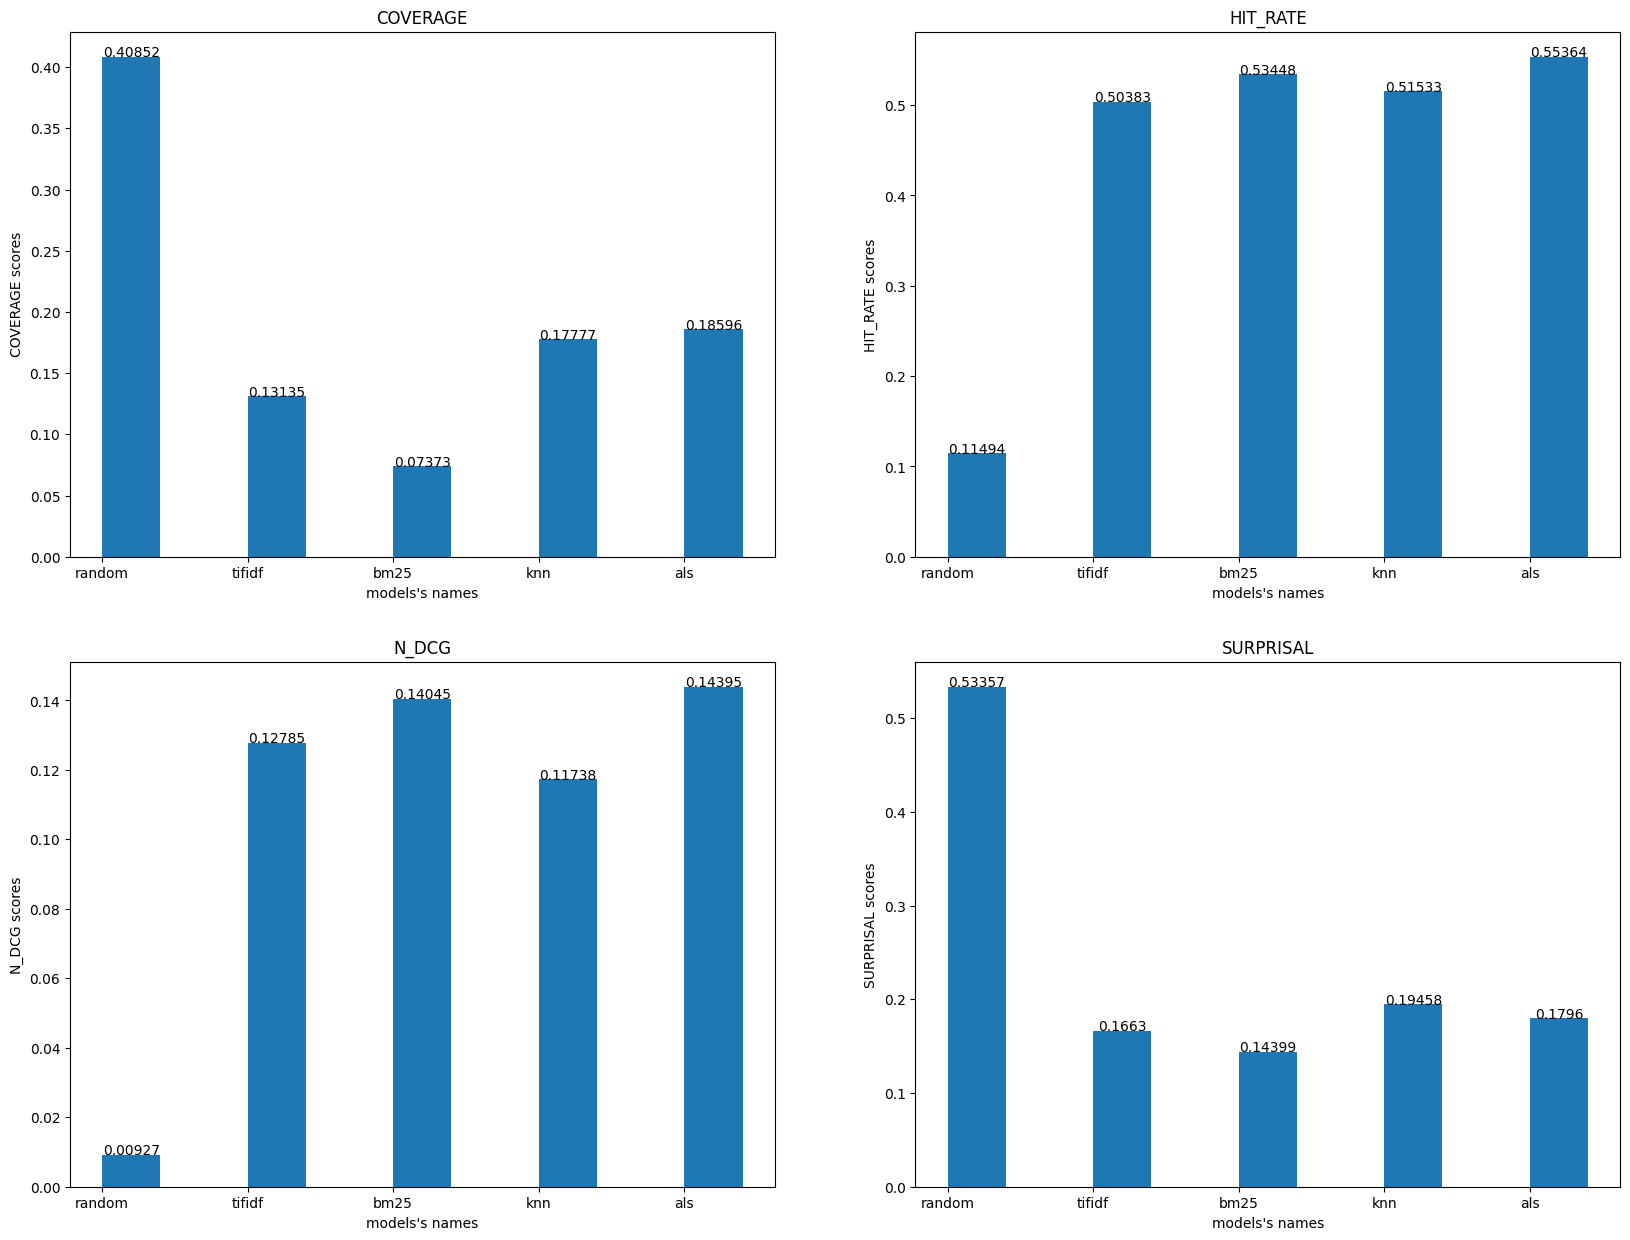

In [173]:
models_names = COVERAGE.keys()

# make x labels for bar plot + some magic for plot view
x_ticks = np.arange(0, len(models_names)*5, 5)
standart_width = 2


plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.bar(x_ticks + standart_width/2, COVERAGE.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, COVERAGE.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("COVERAGE scores")
plt.title(f"COVERAGE")

plt.subplot(2,2,2)
plt.bar(x_ticks + standart_width/2, HIT_RATE.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, HIT_RATE.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("HIT_RATE scores")
plt.title(f"HIT_RATE")

plt.subplot(2,2,3)
plt.bar(x_ticks + standart_width/2, N_DCG.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, N_DCG.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("N_DCG scores")
plt.title(f"N_DCG")

plt.subplot(2,2,4)
plt.bar(x_ticks + standart_width/2, SURPRISAL.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, SURPRISAL.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("SURPRISAL scores")
plt.title(f"SURPRISAL")

Сделаем некоторые выводы по наблюдаемым результатам и проделанной работе:
- На примере тестового пользователя можно видеть результат работы каждой из рекомендательных моделей. Можно посмотреть на список фильмов, просмотренных пользователем, а затем на список рекомендованных ему фильмов. Самый простой способ понять а работает ли вообще рекомендательная модель -- сравнить жанры просмотренных и рекомендованных фильмов. Видно что более менее жанры совпадают, а значит, рекомендательные модели выучили некоторорые зависимоти (довольно логично, что, как правило, конкретный человек предпочитает фильмы конкретных данров).
- Увеличение соседей в модели knn, как и увеличение количества факторов в модели ALS увеличивает оценку модели. Однако, слишком сильное увеличение гиперпараметров может привести к переобучению модели.
- Baseline модель, делающая случайные рекомендации имеет самые высокие оценки coverage и surprisal. Это не удивительно, если вспомнить смысл этих оценок (см. выше). Поскольку рекомендации случайны, рекомендованный список является как наиболее разнообразным, так и наиболее неожиданным для пользователя. В то же время, остальные модели выучивали зависимости, связанные с предпочитаемыми жанрами и другими параметрами, поэтому разнообрарзие рекомендованных фильмов меньше.
- Что же касается непосредственно оценок качества "попадания в запросы" пользователя, все модели смогли значительно превзойти случайные рекомендации. Абсолютным лидером по всем оценкам является модель ALS.
- Knn, tfidf и bm25 используют один и тот же алгоритм (ближайшие соседи на основе косинусного расстояния), однако видно, что взвешивание оценок пользователей (tfidf или bm25) дало незначительный прирост оценки модели -- примерно от 2% до 8% (хотя, наверное не стоит делать поспешных заявлений о том, что можно считать "незначительным" приростом; в данном случае, имеется ввиду незначительный по сравнению с приростом, который дает ALS).